# Import Packages

In [1]:

from Cloud_Loader import CloudDataset
# from GPUtil import showUtilization as gpu_usage
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
from PIL import Image
from UNET_Network import UNET
import time
import torch
from torch.utils.data import Dataset, DataLoader, sampler
from torch import cuda, nn
from torchmetrics import ConfusionMatrix

# Adjustables

In [2]:
# Minibatch Size
batch_size = 24

# learning rate
learning_rate = 0.001

# Import Data

## Import and Split Data

Keeping the same split so as to have consistency between the two datasets

In [3]:
# Set the base path and load in the dataset 
base_path = Path('Data/95-cloud_training')

data = CloudDataset(base_path/'train_red', 
                    base_path/'train_green', 
                    base_path/'train_blue', 
                    base_path/'train_nir',
                    base_path/'train_gt')


# Split into training and testing data
train_ds , valid_ds , test_ds = torch.utils.data.random_split(data,
                                                                                        [ 0.6 , 0.2 , 0.2 ], # 60, 20, 20 data split
                                                                                        # generator to keep things consistent 
                                                                                        generator=torch.Generator().manual_seed(42)
                                                                                        )

# Load training, validation, and testing data
train_dl = DataLoader(train_ds, 
                                    batch_size=batch_size, 
                                    shuffle=True)

valid_dl = DataLoader(valid_ds, 
                                    batch_size=batch_size, 
                                    shuffle=True)

test_dl = DataLoader(test_ds ,
                                    batch_size = batch_size, 
                                    shuffle = True)

print(f' training dataset length: {len(test_ds)}')

display(len(test_ds))

 training dataset length: 6940


6940

# Model Evaluation

## Load the previous weights

In [4]:
# set the path to the modeled weights
path = 'Results/UNET_Raw_Weights.pth'
# path = 'UNET_Raw_Weights.pth'

# send everything to the GPU if available
dev = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f' Running on {dev} ')

# apply 4 chanels in to binary mask
unet = UNET(4 , 2).to(dev)

# Load previous weights
unet.load_state_dict(torch.load(path))

# print out the network design
unet.eval()

 Running on cuda:0 


UNET(
  (conv1): Sequential(
    (0): Conv2d(4, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kerne

## Define the Testing Loop

In [5]:
def test_loop(dataloader, model, loss_fn, valid_or_test_flag =  "test"):
    size = len(dataloader.dataset)
    test_loss, correct = 0 , 0
    running_acc = 0.0
    with torch.no_grad():
        for X,y in dataloader:
            X = X.to(dev)
            y = y.to(dev)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct = acc_metric(pred, y)
            running_acc  += correct*dataloader.batch_size
            # print(pred)

    test_loss /= size

    if valid_or_test_flag == "test":
        print(f"Test Results: \n Accuracy {(100*correct):>0.1f}%, Avg. loss: {test_loss:>8f} \n")
    
    else: 
        print(f"Validation Error: \n Accuracy {(100*correct):>0.1f}%, Avg. loss: {test_loss:>8f} \n")

def acc_metric(predb, yb):
    return (predb.argmax(dim=1) == yb.to(dev)).float().mean()

# Run the Test

In [6]:
loss_fn = nn.CrossEntropyLoss()
test_loop(test_dl , unet, loss_fn , valid_or_test_flag = "test")

Test Results: 
 Accuracy 75.1%, Avg. loss: 0.004688 



In [7]:
# Transfer the batch to images
def batch_to_img(xb, idx):
    img = np.array(xb[idx,0:3])
    return img.transpose((1,2,0))

# Predictions to of
def predb_to_mask(predb, idx):
    p = torch.functional.F.argmax(predb[idx], 0)
    return p.argmax(0).cpu()

xb, yb = next(iter(train_dl))

with torch.no_grad():
    predb = unet(xb.to(dev))
predb.shape

torch.Size([24, 2, 384, 384])

# Sample Test Image

In [8]:
len(dataloader.dataset)

NameError: name 'dataloader' is not defined

Find a goodimage from batch

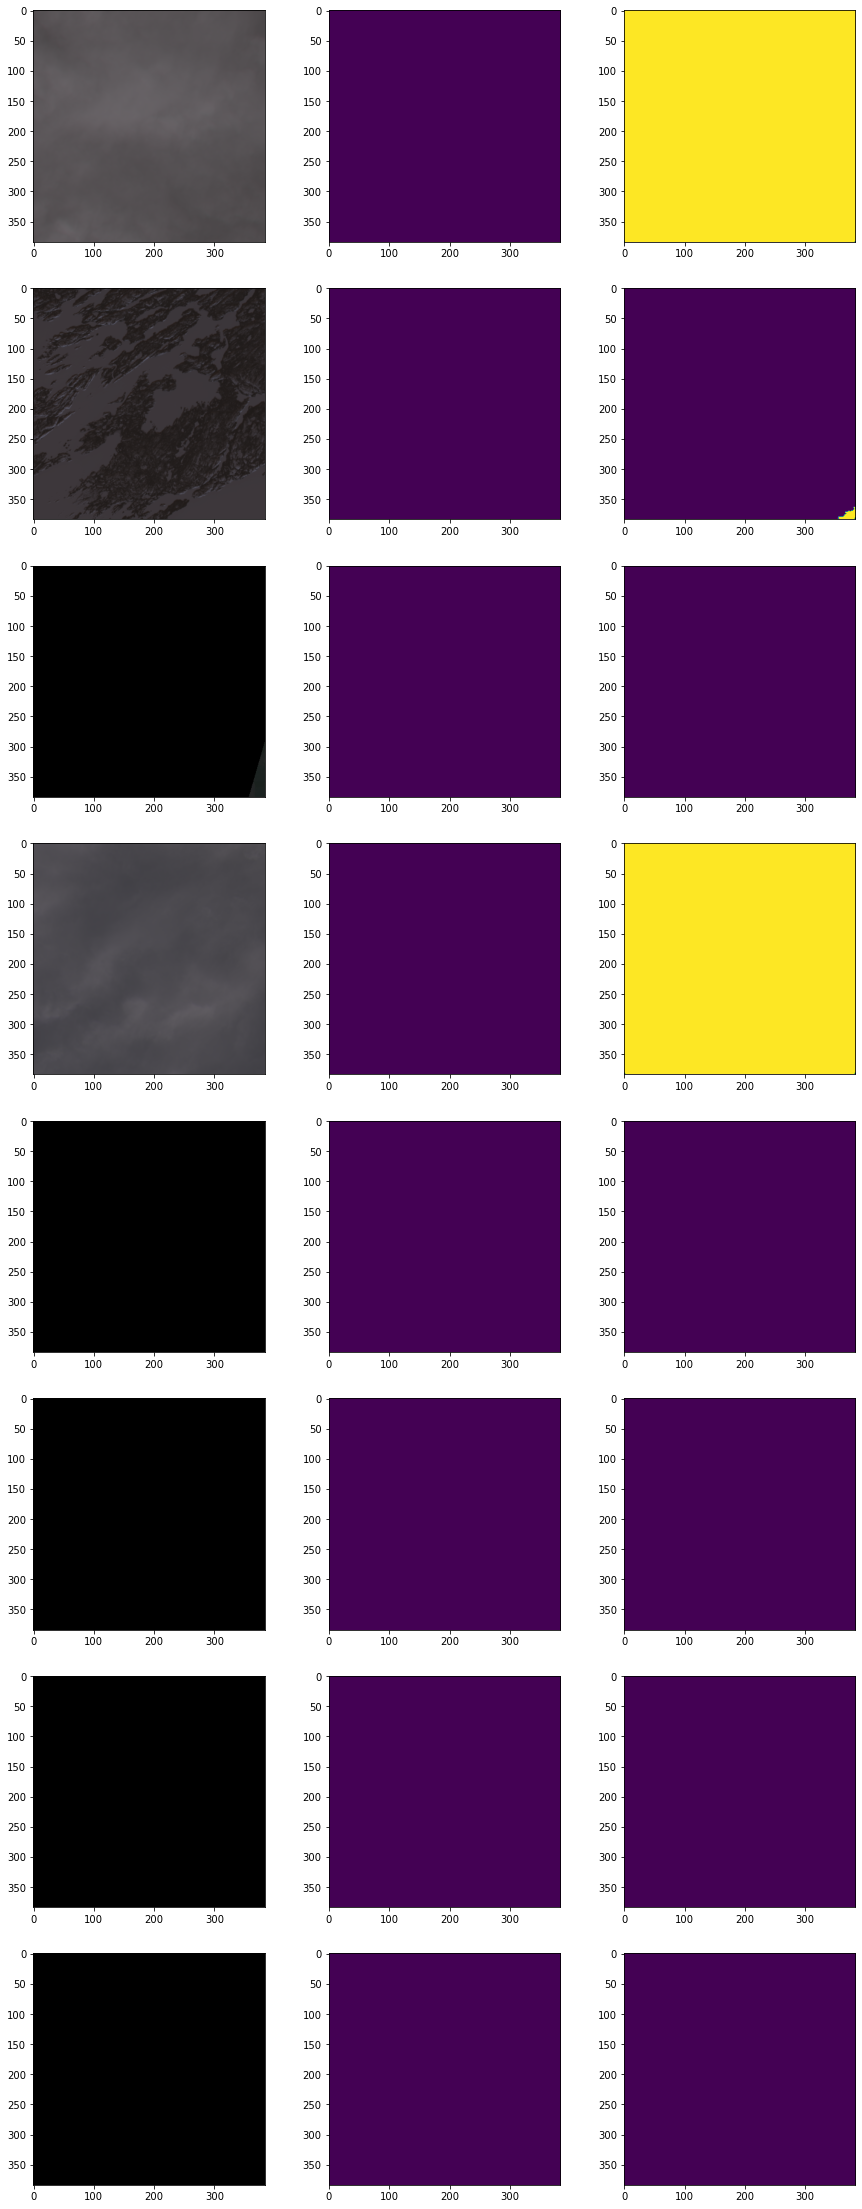

In [ ]:
bs = 8
fig, ax = plt.subplots(bs,3, figsize=(15,bs*5))
for i in range(bs):
    ax[i,0].imshow(batch_to_img(xb,i))
    ax[i,1].imshow(yb[i])
    ax[i,2].imshow(predb_to_mask(predb, i))